In [72]:
import os
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
import re

def exp_func(t, a, b, tau):
    """
    Function to be used for the curve fitting requires:
    t (float): Time parameter
    a (float): Baseline value or noise
    b (float): Pre-exponential factor such that a + b * exp(-0/tau) ~ peak val
    tau (float): Lifetime
    """
    return a + b*np.exp(-t/tau)

def searcher(string):
    """
    Finds any file with the specified extension, requires a string to search
    """
    file = re.compile(r'^[^~$].+\.txt')
    return file.search(string)

def file_adder():
    """
    returns a list with all the csv files in the local directory, note for windows change "/" to "\\"
    """
    directory = os.getcwd()
    files =[]
    filenames = []
    for elements in os.listdir(directory):
        if searcher(elements):
            files.append(directory+"/"+elements)
            filenames.append(elements.strip(".txt")+".png")
    return files, filenames

def file_opener(address, separator):
    """
    Opens the file in the specified address and splits them around the set separator. Requires:
    address (string): The location of the file as found file adder
    separator (string): The type of separator for the data. "\t" for tab, " " for space, "\n" for newline, "," for commas,
    etc.
    """
    file_handle = open(address, "r")
    result = []
    for lines in file_handle:
        processed = lines.split(separator)
        try: #Attempts to convert to number
            float(processed[0])
            part1 = float(processed[0].strip("\n").strip(" "))
            part2 = float(processed[1].strip("\n").strip(" "))
            result.append((part1, part2))
        except: #If unable to convert to number, move to the next line
            continue
        
    return result

def process_data(list_of_tuples, figname, displayfig = True, savefig = False):
    """
    Converts the exponential decay of the sample to lifetime ms, displays fig and saves fig (if enabled) requires:
    list_of_tuples (list): List with the data in the format (time, intensity counts)
    figname (string): A list with the names for the figure, in this case taken from the filename
    displayfig (bool): If set to true will display the plot of the curve fitting (red) vs the measurements (blue pixels),
    default values = True
    savefig (bool) = Will save the previous figure as a .png file in the current directory, default set to false
    """
    sz = len(list_of_tuples) #Initial size, the same as the number of measurements
    x_data = np.zeros(sz)
    y_data = np.zeros(sz)
    count = 0
    for elements in list_of_tuples: #Set the x and y_data
        x_data[count] = elements[0]
        y_data[count] = elements[1]
        count += 1
    count = 0
    max_val = np.argmax(y_data) #Find the max value point. This is approximately the starting position of the decay
    len_of_y_data = len(y_data[max_val:]) #Find the new size of y_data
    y_data = y_data[max_val:] #Start data from max to the end
    x_data = x_data[:len_of_y_data] #start data from 0 to length of y_data
    
    #Curve fit using bounded Trust Region Reflective algorithm
    popt, pcov = curve_fit(exp_func, 
                x_data, 
                y_data, 
                #p0 = (np.average(y_data[int(len(y_data) * 2/3):]), np.amax(y_data), 1.0e4), #Guess start, not necessary
                maxfev = 100000,
                #boundary: a = 0 to 1.5 times noise, b = 0 to 1.5 times max val, tau = 0 to 100 ms, this should cover
                #pretty much every case
                bounds = ([0.,0., 0.], [np.average(y_data[int(len(y_data) * 2/3):]) * 1.5, np.amax(y_data) * 1.5, 100e6]),
                #Method: trf generally robust method, requires boundaries, if boundaries not known use lm
                method = 'trf') #lm =  Levenberg-Marquardt alg., trf = Trust Region Reflective alg., dogbox = dogleg alg.
    
    plt.plot(x_data, exp_func(x_data, *popt), 'r-', label='curve fit') 
    plt.plot(x_data, y_data, 'b,', label='Measured data')
    plt.xlabel('time in ns')
    plt.ylabel('Counts')
    plt.legend()
    if savefig == True:
        plt.savefig(figname)
    if displayfig == True:
        plt.show()
    print(popt)
    return popt, pcov

def return_lifetime_ms(separator, savefig = True, displayfig = True):
    lifetimes = []
    result = []
    file_list, fignames = file_adder()
    count = 0
    for file in file_list:
        list_of_tuples = file_opener(file, separator)
        popt, pcov = process_data(list_of_tuples, fignames[count], savefig, displayfig)
        lifetimes.append((popt[2]/1e6))
        count += 1
    count = 0
    for elements in lifetimes:
        lifetimes[count] = float(str(round(elements, 2))[0:4])
        result.append((fignames[count], lifetimes[count]))
        count += 1
    return result

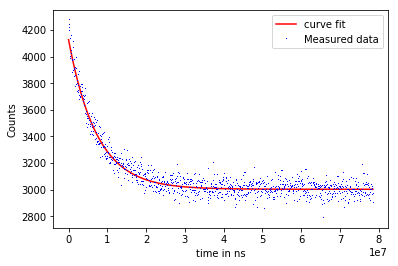

[  3.00319314e+03   1.12401256e+03   7.26613704e+06]


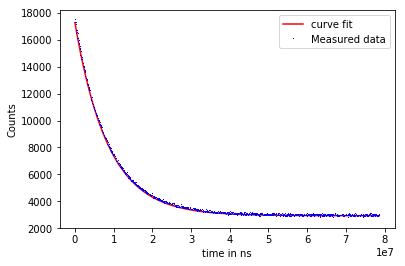

[  2.92999142e+03   1.43329110e+04   8.55178439e+06]


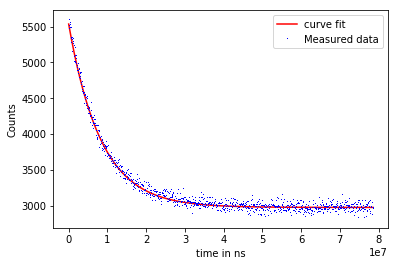

[  2.97617034e+03   2.55961096e+03   8.32770036e+06]


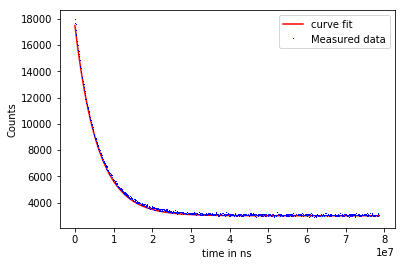

[  3.00653210e+03   1.44778400e+04   5.86876547e+06]


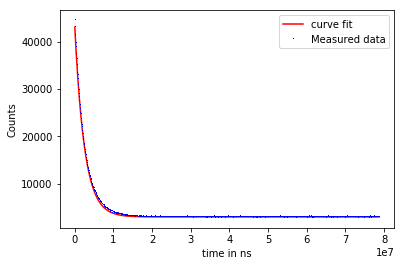

[    3052.70602823    39976.17413562  2509305.19814412]
[('EY1_3 lifetime.png', 7.27), ('EY2_2 lifetime.png', 8.55), ('EY1_2 lifetime.png', 8.33), ('EY1 lifetime.png', 5.87), ('EY2 lifetime.png', 2.51)]


In [73]:
lifetime = return_lifetime_ms("\t", True, False) #arguments are: separator, display plot, save plot
print(lifetime) #prints the list of tuples (figurename, lifetime in milliseconds)